In [3]:
#ライブラリをインポート
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from ydata_profiling import ProfileReport
import optuna
print("Importが完了しました")

Importが完了しました


In [4]:
#データを読み込む
path ="/kaggle/input/titanic/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
df = pd.concat([train , test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [5]:
#Nameから敬称を抽出してカウントする
Titles = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df["Title"] = Titles 

df["Title"].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

In [6]:
#敬称をまとめる
df["Title"] = df["Title"].replace(["Mlle","Ms"] ,"Miss")
df["Title"] = df["Title"].replace(["Mme","Lady"] ,"Mrs")
df["Title"] = df["Title"].replace(["Dona" , "Countess" , "Dr","Rev" , "Don" , "Major" , "Col" , "Sir" , "Capt" , "Jonkheer"] ,"Rare")
print(df["Title"].value_counts())
print(df['Title'].info())

Title
Mr        757
Miss      264
Mrs       199
Master     61
Rare       28
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 1309 entries, 0 to 417
Series name: Title
Non-Null Count  Dtype 
--------------  ----- 
1309 non-null   object
dtypes: object(1)
memory usage: 20.5+ KB
None


Fare
8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
7.7417      1
8.1583      1
8.4583      1
7.8000      1
7.7208      1
Name: count, Length: 281, dtype: int64
(array([732., 275.,  64.,  69.,  69.,  16.,  13.,  15.,  14.,   4.,   0.,
         0.,  13.,   5.,   3.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]), array([  0.     ,  17.07764,  34.15528,  51.23292,  68.31056,  85.3882 ,
       102.46584, 119.54348, 136.62112, 153.69876, 170.7764 , 187.85404,
       204.93168, 222.00932, 239.08696, 256.1646 , 273.24224, 290.31988,
       307.39752, 324.47516, 341.5528 , 358.63044, 375.70808, 392.78572,
       409.86336, 426.941  , 444.01864, 461.09628, 478.17392, 495.25156,
       512.3292 ]), <BarContainer object of 30 artists>)


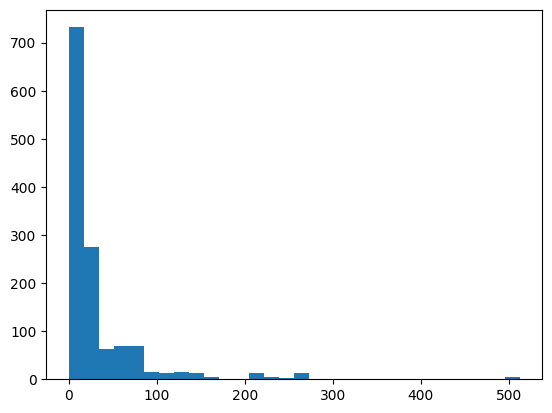

In [7]:
#欠損値を埋める。Fareをとりあえず中央値で埋める。
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
print(df['Fare'].value_counts())
print(plt.hist(data=df , x="Fare", bins=30))

Fare_loge
2.202765    60
2.639057    59
2.169054    55
3.295837    50
2.185579    49
            ..
2.168105     1
2.214661     1
2.246893     1
2.174752     1
2.165711     1
Name: count, Length: 281, dtype: int64
(array([ 17.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,  17., 421.,
        76., 107.,  93.,  51., 131.,  89.,  41.,  25.,  60.,  44.,  50.,
        13.,  17.,  16.,  13.,  21.,   0.,   0.,   4.]), array([0.        , 0.20803058, 0.41606116, 0.62409174, 0.83212231,
       1.04015289, 1.24818347, 1.45621405, 1.66424463, 1.87227521,
       2.08030578, 2.28833636, 2.49636694, 2.70439752, 2.9124281 ,
       3.12045868, 3.32848926, 3.53651983, 3.74455041, 3.95258099,
       4.16061157, 4.36864215, 4.57667273, 4.78470331, 4.99273388,
       5.20076446, 5.40879504, 5.61682562, 5.8248562 , 6.03288678,
       6.24091735]), <BarContainer object of 30 artists>)


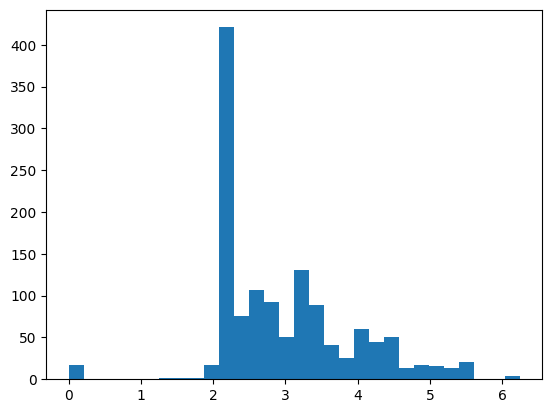

In [8]:
#その後、対数変換して分布を整える
df['Fare_loge'] = np.log1p(df["Fare"])
print(df['Fare_loge'].value_counts())
print(plt.hist(data=df , x="Fare_loge", bins=30))

Age
29.0    206
22.0     94
24.0     47
21.0     41
30.0     40
       ... 
23.5      1
20.5      1
55.5      1
66.0      1
38.5      1
Name: count, Length: 99, dtype: int64


(array([ 34.,  30.,  16.,  14.,  13.,  35.,  62.,  94., 169.,  66., 271.,
         89.,  43.,  92.,  53.,  32.,  40.,  37.,  24.,  18.,  23.,  11.,
         16.,  14.,   4.,   1.,   5.,   1.,   1.,   1.]),
 array([ 0.17 ,  2.831,  5.492,  8.153, 10.814, 13.475, 16.136, 18.797,
        21.458, 24.119, 26.78 , 29.441, 32.102, 34.763, 37.424, 40.085,
        42.746, 45.407, 48.068, 50.729, 53.39 , 56.051, 58.712, 61.373,
        64.034, 66.695, 69.356, 72.017, 74.678, 77.339, 80.   ]),
 <BarContainer object of 30 artists>)

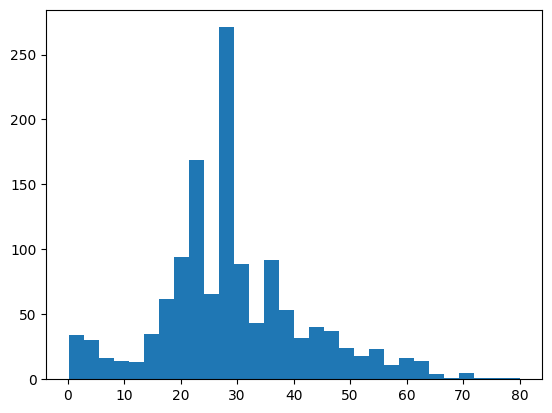

In [9]:
#AgeはTitleごとの中央値で埋める
df["Age"] = df["Age"].fillna(df.groupby("Title")["Age"].transform("median"))
df.isnull().sum()
print(df["Age"].value_counts())
plt.hist(df["Age"], bins=30)

In [11]:
#Embarkedは最頻値で埋める
#最頻値が複数あるため[0]で最初の値を取り出す
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0]) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  Fare_loge    1309 non-null   float64
dtypes: float64(4), int64(4), object(6)
memory usage: 153.4+ KB


In [12]:
#特徴量エンジニアリング
#EmbarkedとSexとTitleをワンホットエンコーディングする。
emb = pd.get_dummies(df["Embarked"],prefix="Emb")
sx = pd.get_dummies(df["Sex"],prefix="Sex")
ttl = pd.get_dummies(df["Title"],prefix="Title")

#新しい特徴量として、Famsize,Isalone,IsFareZeroを追加する。
df["Famsize"] = df["SibSp"] + df["Parch"] + 1
df["Isalone"] = df["Famsize"]==1
df["IsFareZero"] = df["Fare"]==0

#追加した特徴量をデータフレームへ統合する。不要なカラムは削除する。
df2 = pd.concat([df, emb, sx, ttl],axis=1)
df3 = df2.drop(columns=["Fare", "Sex_male", "Embarked", "Sex", "Title", "Cabin", "Ticket", "Name"])

df3.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare_loge,Famsize,Isalone,IsFareZero,Emb_C,Emb_Q,Emb_S,Sex_female,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0.0,3,22.0,1,0,2.110213,2,False,False,False,False,True,False,False,False,True,False,False
1,2,1.0,1,38.0,1,0,4.280593,2,False,False,True,False,False,True,False,False,False,True,False
2,3,1.0,3,26.0,0,0,2.188856,1,True,False,False,False,True,True,False,True,False,False,False
3,4,1.0,1,35.0,1,0,3.990834,2,False,False,False,False,True,True,False,False,False,True,False
4,5,0.0,3,35.0,0,0,2.202765,1,True,False,False,False,True,False,False,False,True,False,False


In [13]:
#機械学習モデルに投入するデータを作成する。
train_df = df3[~df3["Survived"].isnull()]
test_df = df3[df3["Survived"].isnull()]

train_x = train_df.drop(columns=["Survived"])
train_y = train_df["Survived"]
train_y.info()

<class 'pandas.core.series.Series'>
Index: 891 entries, 0 to 890
Series name: Survived
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


# ↓ランダムフォレスト

In [ ]:
# ランダムフォレストモデル（分類器）の定義
# n_estimators: 使用する決定木の数（一般的に多いほど性能が向上するが、計算時間が増える）
# max_depth: 決定木の深さの最大値（過学習を防ぐために設定することが多い）
rf_model = RandomForestClassifier(
    n_estimators=200,      # 適切な木の本数
    max_depth=7,           # 深さを制限（過学習対策）
    min_samples_split=10,  # 分岐の条件を厳しくする
    min_samples_leaf=5,    # 葉のサイズを大きくする
    random_state=42,
    n_jobs=-1
)

# **↓LithtGBM**

In [43]:
#機械学習モデルを呼び出し、学習を行う。
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.03,    # 低めに設定
    n_estimators=150,      # 試行回数
    num_leaves=8,          # 浅い木に制限（過学習対策）
    max_depth=5,           # 深さの制限
    random_state=42,
)
print("LightGBMのハイパーパラメータを設定しました。")

LightGBMのハイパーパラメータを設定しました。


In [44]:
#↓どちらのモデルで学習するか、選んでネ！
#rf_model.fit(train_x , train_y)
lgb_model.fit(train_x , train_y)

print("学習が完了しました")

学習が完了しました


In [45]:
#交差検証を開始する。5分割がよさそう。
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# cross_val_scoreで精度（accuracy）を計算
# scoring='accuracy' はタイタニックの評価指標
accuracy_scores = cross_val_score(
    estimator=lgb_model, 
    X=train_x, 
    y=train_y, 
    cv=skf, 
    scoring='accuracy',
    n_jobs=-1 # 全てのコアを使って並列処理（高速化）
)

# 結果の表示
print(f"各分割での精度スコア ({N_SPLITS}-Fold): {accuracy_scores}")
print(f"----------------------------------------")
print(f"平均精度 (Mean Accuracy): {accuracy_scores.mean():.4f}")
print(f"スコアの標準偏差 (Std Dev): {accuracy_scores.std():.4f}")

各分割での精度スコア (5-Fold): [0.84357542 0.84269663 0.81460674 0.82022472 0.82022472]
----------------------------------------
平均精度 (Mean Accuracy): 0.8283
スコアの標準偏差 (Std Dev): 0.0123


In [ ]:
test_df.tail()

In [46]:
#予測用データの作成をする
test_x = test_df.drop(columns=["Survived"])
test_y = test_df["Survived"]
print("予測用データの作成が完了しました")

予測用データの作成が完了しました


In [47]:
#学習したパラメータをテストデータへ適用して予測する。
test_y = lgb_model.predict(test_x)

#提出用のデータを作る。
submission_df = pd.DataFrame({
    "PassengerId" : test_df["PassengerId"],
    "Survived" : test_y.astype(int)
})

#csvで書き出す
submission_df.to_csv("first_submission16_IsFareZero_farelog_Emb.csv" , index=False)
print("書き出しが完了しました")

書き出しが完了しました


In [ ]:
submission_df.info()

In [ ]:
# プロファイルレポートの生成
profile = ProfileReport(train_df, title='My Data Profiling Report')
# HTMLファイルとして保存
profile.to_file("my_report.html")

In [ ]:
farezero =train_df[train_df["Fare"]==0]
farezero

次：
①ランダムフォレストに変えてみる→LithtGBMよりスコアが伸びなそう。
ハイパーパラメータチューニングを頑張ってみる。→結構よい感じになってきた。

②Fare=0の乗客がかなりいる。調べてみると、ほぼ生き残っていないので、新しい特徴量（IsFareZero）を作ってみる。→スコア変わらず。

③Fareの最大値が大きいため、対数変換をして新しい特徴量として加える→スコア変わらず

④Embarkedを特徴量に追加。→そのままではスコアが下がった。→num_leavesとdepthを2ずつ増やしてみた→めっちゃ下がったからもどした。Optunaで最適化したがやはりスコアは伸びない。この変数は削除したほうが良さそう。

⑤Embarkedを削除して、再度Optunaを試してみる